In [1]:
import mpramnist
from mpramnist.Sure.dataset import SureDataset

from mpramnist.models import HumanLegNet
from mpramnist.models import initialize_weights
from mpramnist.trainers import LitModel_Sure_Clas, LitModel_Sure_Reg

from mpramnist import transforms as t
from mpramnist import target_transforms as t_t

import torch
import torch.nn as nn
import lightning.pytorch as L
import torch.utils.data as data
from lightning.pytorch.callbacks import ModelCheckpoint

from torchmetrics import PearsonCorrCoef

from torch.nn.utils.rnn import pad_sequence

In [2]:
BATCH_SIZE = 96
NUM_WORKERS = 103

In [3]:
# preprocessing
train_transform = t.Compose(
    [
        t.ReverseComplement(0.5),
        t.Seq2Tensor(),
    ]
)
test_transform = t.Compose(
    [
        t.Seq2Tensor(),
    ]
)


def pad_collate(batch):  # required, because length of sequences is different
    (seq, targets) = zip(*batch)

    seq = pad_sequence(seq, batch_first=True, padding_value=0.25)

    return seq, torch.vstack(targets)

In [4]:
GENOME_IDS = SureDataset.GENOME_IDS
GENOME_IDS

['SuRE42_HG02601', 'SuRE43_GM18983', 'SuRE44_HG01241', 'SuRE45_HG03464']

In [5]:
CELL_TYPES = SureDataset.CELL_TYPES
CELL_TYPES

['K562', 'HepG2']

In [6]:
forw_transform = t.Compose([t.Seq2Tensor()])
rev_transform = t.Compose(
    [
        t.ReverseComplement(1),
        t.Seq2Tensor(),
    ]
)


def meaned_prediction(forw, rev, trainer, seq_model, name):
    predictions_forw = trainer.predict(seq_model, dataloaders=forw)
    targets = torch.cat([pred["target"] for pred in predictions_forw])
    y_preds_forw = torch.cat([pred["predicted"] for pred in predictions_forw])

    predictions_rev = trainer.predict(seq_model, dataloaders=rev)
    y_preds_rev = torch.cat([pred["predicted"] for pred in predictions_rev])

    mean_forw = torch.mean(torch.stack([y_preds_forw, y_preds_rev]), dim=0)

    pears = PearsonCorrCoef(num_outputs=2)
    print(name + " Pearson correlation")

    return pears(mean_forw, targets)

# Classification

In [7]:
task = "classification"

# load the data
train_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[0],
    split="train",
    transform=train_transform,
    root="../data/",
)  # for needed folds
val_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[0],
    split="val",
    transform=test_transform,
    root="../data/",
)  # use "val" for default validation set
test_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[0],
    split="test",
    transform=test_transform,
    root="../data/",
)  # use "test" for default test set

In [8]:
print(train_dataset)
print(50 * "-")
print(val_dataset)
print(25 * "-")
print(test_dataset)
print(50 * "-")

Dataset SureDataset of size 619051 (MpraDaraset)
    Number of datapoints: 619051
    Used split fold: train
--------------------------------------------------
Dataset SureDataset of size 73935 (MpraDaraset)
    Number of datapoints: 73935
    Used split fold: val
-------------------------
Dataset SureDataset of size 73947 (MpraDaraset)
    Number of datapoints: 73947
    Used split fold: test
--------------------------------------------------


In [9]:
N_CLASSES = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [10]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

val_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

test_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

In [11]:
model = HumanLegNet(
    in_ch=in_channels,
    output_dim=N_CLASSES,
    stem_ch=64,
    stem_ks=11,
    ef_ks=9,
    ef_block_sizes=[80, 96, 112, 128],
    pool_sizes=[2, 2, 2, 2],
    resize_factor=4,
)
model.apply(initialize_weights)

seq_model = LitModel_Sure_Clas(
    model=model,
    loss=nn.CrossEntropyLoss(),
    n_classes=N_CLASSES,
    weight_decay=1e-2,
    lr=5e-3,
    print_each=10,
)

In [12]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", mode="min", save_top_k=1, save_last=False
)
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=50,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    callbacks=[checkpoint_callback],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [13]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | HumanLegNet      | 1.3 M  | train
1 | loss          | CrossEntropyLoss | 0      | train
2 | train_pearson | PearsonCorrCoef  | 0      | train
3 | val_pearson   | PearsonCorrCoef  | 0      | train
4 | test_pearson  | PearsonCorrCoef  | 0      | train
-----------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params

Training: |                                                                                    | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…


| Current_epoch: 9.00000 |


----------------------------------------------------------------------------------------------------
| K562: || Precision: 0.35832 | Recall: 0.34085 | Accuracy: 0.34245 | F1: 0.30185 | Val_AUCROC: 0.69091 | Val_AUPR: 0.34158 |
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
| HepG2: || Precision: 0.30406 | Recall: 0.32275 | Accuracy: 0.32550 | F1: 0.27267 | Val_AUCROC: 0.65290 | Val_AUPR: 0.30836 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…


| Current_epoch: 19.00000 |


----------------------------------------------------------------------------------------------------
| K562: || Precision: 0.36486 | Recall: 0.32608 | Accuracy: 0.32822 | F1: 0.29806 | Val_AUCROC: 0.68414 | Val_AUPR: 0.33769 |
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
| HepG2: || Precision: 0.29384 | Recall: 0.32013 | Accuracy: 0.32274 | F1: 0.27445 | Val_AUCROC: 0.64416 | Val_AUPR: 0.30155 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…


| Current_epoch: 29.00000 |


----------------------------------------------------------------------------------------------------
| K562: || Precision: 0.35711 | Recall: 0.34716 | Accuracy: 0.34848 | F1: 0.30735 | Val_AUCROC: 0.69525 | Val_AUPR: 0.34925 |
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
| HepG2: || Precision: 0.32027 | Recall: 0.31879 | Accuracy: 0.32185 | F1: 0.26994 | Val_AUCROC: 0.65219 | Val_AUPR: 0.31055 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…


| Current_epoch: 39.00000 |


----------------------------------------------------------------------------------------------------
| K562: || Precision: 0.37406 | Recall: 0.35290 | Accuracy: 0.35447 | F1: 0.32103 | Val_AUCROC: 0.69666 | Val_AUPR: 0.35124 |
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
| HepG2: || Precision: 0.31629 | Recall: 0.33551 | Accuracy: 0.33813 | F1: 0.29919 | Val_AUCROC: 0.66136 | Val_AUPR: 0.31807 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…


| Current_epoch: 49.00000 |


----------------------------------------------------------------------------------------------------
| K562: || Precision: 0.35503 | Recall: 0.34793 | Accuracy: 0.34916 | F1: 0.32536 | Val_AUCROC: 0.68686 | Val_AUPR: 0.34074 |
----------------------------------------------------------------------------------------------------



`Trainer.fit` stopped: `max_epochs=50` reached.



----------------------------------------------------------------------------------------------------
| HepG2: || Precision: 0.30267 | Recall: 0.31912 | Accuracy: 0.32146 | F1: 0.29025 | Val_AUCROC: 0.64060 | Val_AUPR: 0.29947 |
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                     | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------
| K562: || Precision: 0.37077 | Recall: 0.35674 | Accuracy: 0.35808 | F1: 0.32420 | Val_AUCROC: 0.69862 | Val_AUPR: 0.35202 |
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
| HepG2: || Precision: 0.31452 | Recall: 0.33477 | Accuracy: 0.33750 | F1: 0.28621 | Val_AUCROC: 0.65760 | Val_AUPR: 0.31566 |
----------------------------------------------------------------------------------------------------



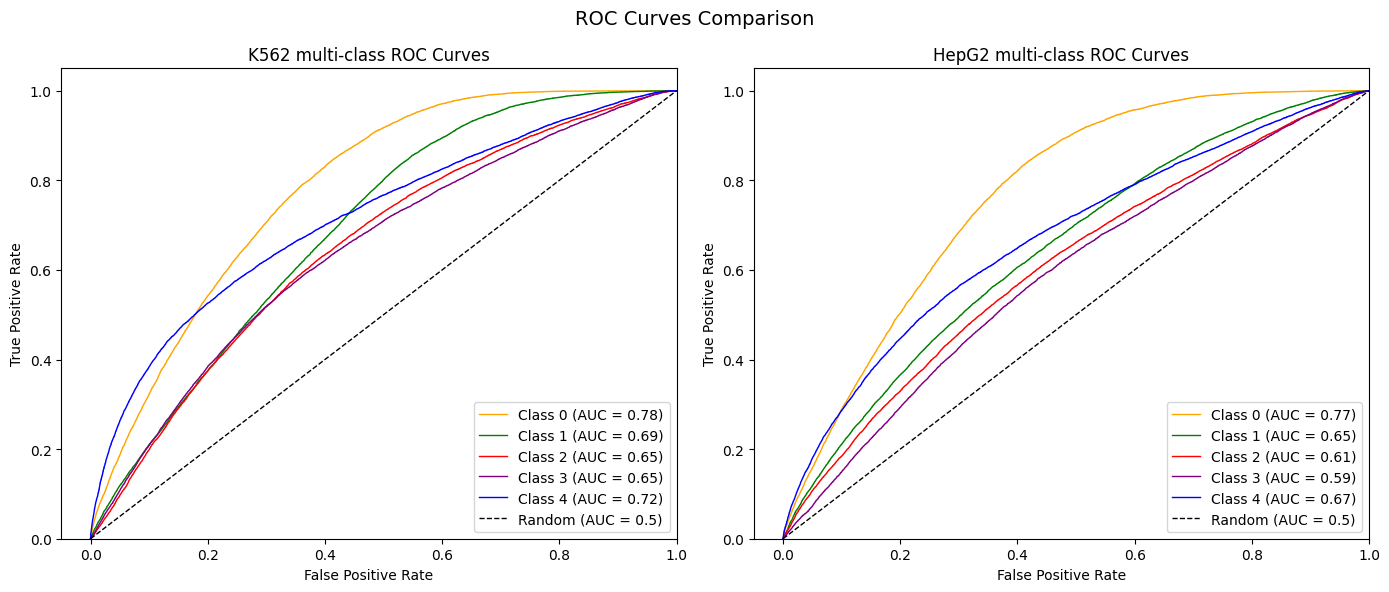

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.9297893047332764
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.9297893047332764}]

In [14]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_Sure_Clas.load_from_checkpoint(
    best_model_path,
    model=model,
    loss=nn.CrossEntropyLoss(),
    n_classes=N_CLASSES,
    weight_decay=1e-2,
    lr=5e-3,
    print_each=1,
)
trainer.test(seq_model, dataloaders=test_loader)

# Regression

In [7]:
task = "regression"

GENOME_IDS = SureDataset.GENOME_IDS
CELL_TYPES = SureDataset.CELL_TYPES

## Together

In [8]:
GENOME_IDS

['SuRE42_HG02601', 'SuRE43_GM18983', 'SuRE44_HG01241', 'SuRE45_HG03464']

In [9]:
train_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS,
    split="train",
    transform=train_transform,
    root="../data/",
)  # for needed folds

val_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS,
    split="val",
    transform=test_transform,
    root="../data/",
)  # use "val" for default validation set

test_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS,
    split="test",
    transform=test_transform,
    root="../data/",
)  # use "test" for default test set

In [10]:
print(train_dataset)
print(50 * "-")
print(val_dataset)
print(25 * "-")
print(test_dataset)
print(50 * "-")

Dataset SureDataset of size 2006071 (MpraDaraset)
    Number of datapoints: 2006071
    Used split fold: train
--------------------------------------------------
Dataset SureDataset of size 259604 (MpraDaraset)
    Number of datapoints: 259604
    Used split fold: val
-------------------------
Dataset SureDataset of size 259782 (MpraDaraset)
    Number of datapoints: 259782
    Used split fold: test
--------------------------------------------------


In [11]:
num_outputs = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [12]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

val_loader = data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

test_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

In [13]:
model = HumanLegNet(
    in_ch=in_channels,
    output_dim=num_outputs,
    stem_ch=64,
    stem_ks=11,
    ef_ks=9,
    ef_block_sizes=[80, 96, 112, 128],
    pool_sizes=[2, 2, 2, 2],
    resize_factor=4,
)
model.apply(initialize_weights)

seq_model = LitModel_Sure_Reg(
    model=model,
    loss=nn.MSELoss(),
    num_outputs=num_outputs,
    weight_decay=1e-2,
    lr=5e-3,
    print_each=25,
)

In [14]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_pearson", mode="max", save_top_k=1, save_last=False
)
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=50,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [15]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                    | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…


--------------------------------------------------------------------------------------------------------------------
| Epoch: 24 | Val Loss: 429.01315 | Val Pearson K562: 0.45979 | Val Pearson HepG2: 0.31687 | Train Pearson: 0.41730 
--------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

`Trainer.fit` stopped: `max_epochs=50` reached.



--------------------------------------------------------------------------------------------------------------------
| Epoch: 49 | Val Loss: 422.27548 | Val Pearson K562: 0.50485 | Val Pearson HepG2: 0.34003 | Train Pearson: 0.49608 
--------------------------------------------------------------------------------------------------------------------



In [16]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_Sure_Reg.load_from_checkpoint(
    best_model_path,
    model=model,
    loss=nn.MSELoss(),
    num_outputs=num_outputs,
    weight_decay=1e-2,
    lr=5e-3,
    print_each=1,
)
trainer.test(seq_model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                     | 0/? [00:00<?,…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            401.1357116699219
   test_pearson HepG2       0.35515379905700684
    test_pearson K562        0.52571040391922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 401.1357116699219,
  'test_pearson K562': 0.52571040391922,
  'test_pearson HepG2': 0.35515379905700684}]

In [17]:
test_forw = SureDataset(
    task=task,
    genome_id=GENOME_IDS,
    split="test",
    transform=forw_transform,
    root="../data/",
)
test_rev = SureDataset(
    task=task,
    genome_id=GENOME_IDS,
    split="test",
    transform=rev_transform,
    root="../data/",
)

forw = data.DataLoader(
    dataset=test_forw,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)
rev = data.DataLoader(
    dataset=test_rev,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

meaned_prediction(forw, rev, trainer, seq_model, "together")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                  | 0/? [00:00<?,…

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                  | 0/? [00:00<?,…

together Pearson correlation


tensor([0.5326, 0.3618])

## SuRE42_HG02601

In [ ]:
SureDataset.GENOME_IDS[0]

In [ ]:
train_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[0],
    split="train",
    transform=train_transform,
    root="../data/",
)  # for needed folds

val_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[0],
    split="val",
    transform=test_transform,
    root="../data/",
)  # use "val" for default validation set

test_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[0],
    split="test",
    transform=test_transform,
    root="../data/",
)  # use "test" for default test set

In [ ]:
num_outputs = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [ ]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

val_loader = data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

test_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

In [ ]:
model = HumanLegNet(
    in_ch=in_channels,
    output_dim=num_outputs,
    stem_ch=64,
    stem_ks=11,
    ef_ks=9,
    ef_block_sizes=[80, 96, 112, 128],
    pool_sizes=[2, 2, 2, 2],
    resize_factor=4,
)
model.apply(initialize_weights)

seq_model = LitModel_Sure_Reg(
    model=model,
    loss=nn.MSELoss(),
    num_outputs=num_outputs,
    weight_decay=1e-2,
    lr=5e-3,
    print_each=25,
)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_pearson", mode="max", save_top_k=1, save_last=False
)
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=50,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback],
)

In [ ]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_Sure_Reg.load_from_checkpoint(
    best_model_path,
    model=model,
    loss=nn.MSELoss(),
    num_outputs=num_outputs,
    weight_decay=1e-2,
    lr=5e-3,
    print_each=1,
)
trainer.test(seq_model, dataloaders=test_loader)

In [ ]:
test_forw = SureDataset(
    task=task,
    genome_id=GENOME_IDS[0],
    split="test",
    transform=forw_transform,
    root="../data/",
)
test_rev = SureDataset(
    task=task,
    genome_id=GENOME_IDS[0],
    split="test",
    transform=rev_transform,
    root="../data/",
)

forw = data.DataLoader(
    dataset=test_forw,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)
rev = data.DataLoader(
    dataset=test_rev,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

meaned_prediction(forw, rev, trainer, seq_model, GENOME_IDS[0])

## SuRE43_GM18983

In [ ]:
GENOME_IDS[1]

In [ ]:
train_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[1],
    split="train",
    transform=train_transform,
    root="../data/",
)  # for needed folds

val_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[1],
    split="val",
    transform=test_transform,
    root="../data/",
)  # use "val" for default validation set

test_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[1],
    split="test",
    transform=test_transform,
    root="../data/",
)  # use "test" for default test set

In [ ]:
num_outputs = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [ ]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

val_loader = data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

test_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

In [ ]:
model = HumanLegNet(
    in_ch=in_channels,
    output_dim=num_outputs,
    stem_ch=64,
    stem_ks=11,
    ef_ks=9,
    ef_block_sizes=[80, 96, 112, 128],
    pool_sizes=[2, 2, 2, 2],
    resize_factor=4,
)
model.apply(initialize_weights)

seq_model = LitModel_Sure_Reg(
    model=model,
    loss=nn.MSELoss(),
    num_outputs=num_outputs,
    weight_decay=1e-2,
    lr=5e-3,
    print_each=25,
)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_pearson", mode="max", save_top_k=1, save_last=False
)
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=50,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback],
)

In [ ]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_Sure_Reg.load_from_checkpoint(
    best_model_path,
    model=model,
    loss=nn.MSELoss(),
    num_outputs=num_outputs,
    weight_decay=1e-2,
    lr=5e-3,
    print_each=1,
)
trainer.test(seq_model, dataloaders=test_loader)

In [ ]:
test_forw = SureDataset(
    task=task,
    genome_id=GENOME_IDS[1],
    split="test",
    transform=forw_transform,
    root="../data/",
)
test_rev = SureDataset(
    task=task,
    genome_id=GENOME_IDS[1],
    split="test",
    transform=rev_transform,
    root="../data/",
)

forw = data.DataLoader(
    dataset=test_forw,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)
rev = data.DataLoader(
    dataset=test_rev,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

meaned_prediction(forw, rev, trainer, seq_model, GENOME_IDS[1])

## SuRE44_HG01241

In [18]:
GENOME_IDS[2]

'SuRE44_HG01241'

In [19]:
train_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[2],
    split="train",
    transform=train_transform,
    root="../data/",
)  # for needed folds

val_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[2],
    split="val",
    transform=test_transform,
    root="../data/",
)  # use "val" for default validation set

test_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[2],
    split="test",
    transform=test_transform,
    root="../data/",
)  # use "test" for default test set

In [20]:
num_outputs = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [21]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

val_loader = data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

test_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

In [22]:
model = HumanLegNet(
    in_ch=in_channels,
    output_dim=num_outputs,
    stem_ch=64,
    stem_ks=11,
    ef_ks=9,
    ef_block_sizes=[80, 96, 112, 128],
    pool_sizes=[2, 2, 2, 2],
    resize_factor=4,
)
model.apply(initialize_weights)

seq_model = LitModel_Sure_Reg(
    model=model,
    loss=nn.MSELoss(),
    num_outputs=num_outputs,
    weight_decay=1e-2,
    lr=5e-3,
    print_each=25,
)

In [23]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_pearson", mode="max", save_top_k=1, save_last=False
)
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=50,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [24]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                    | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…


--------------------------------------------------------------------------------------------------------------------
| Epoch: 24 | Val Loss: 376.83768 | Val Pearson K562: 0.57760 | Val Pearson HepG2: 0.29445 | Train Pearson: 0.45271 
--------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

`Trainer.fit` stopped: `max_epochs=50` reached.



--------------------------------------------------------------------------------------------------------------------
| Epoch: 49 | Val Loss: 420.39453 | Val Pearson K562: 0.54413 | Val Pearson HepG2: 0.20372 | Train Pearson: 0.72351 
--------------------------------------------------------------------------------------------------------------------



In [25]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_Sure_Reg.load_from_checkpoint(
    best_model_path,
    model=model,
    loss=nn.MSELoss(),
    num_outputs=num_outputs,
    weight_decay=1e-2,
    lr=5e-3,
    print_each=1,
)
trainer.test(seq_model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                     | 0/? [00:00<?,…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            379.7020568847656
   test_pearson HepG2       0.30991441011428833
    test_pearson K562       0.5640450119972229
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 379.7020568847656,
  'test_pearson K562': 0.5640450119972229,
  'test_pearson HepG2': 0.30991441011428833}]

In [26]:
test_forw = SureDataset(
    task=task,
    genome_id=GENOME_IDS[2],
    split="test",
    transform=forw_transform,
    root="../data/",
)
test_rev = SureDataset(
    task=task,
    genome_id=GENOME_IDS[2],
    split="test",
    transform=rev_transform,
    root="../data/",
)

forw = data.DataLoader(
    dataset=test_forw,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)
rev = data.DataLoader(
    dataset=test_rev,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

meaned_prediction(forw, rev, trainer, seq_model, GENOME_IDS[2])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                  | 0/? [00:00<?,…

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                  | 0/? [00:00<?,…

SuRE44_HG01241 Pearson correlation


tensor([0.5738, 0.3171])

## SuRE45_HG03464

In [27]:
GENOME_IDS[3]

'SuRE45_HG03464'

In [28]:
train_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[3],
    split="train",
    transform=train_transform,
    root="../data/",
)  # for needed folds

val_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[3],
    split="val",
    transform=test_transform,
    root="../data/",
)  # use "val" for default validation set

test_dataset = SureDataset(
    task=task,
    genome_id=GENOME_IDS[3],
    split="test",
    transform=test_transform,
    root="../data/",
)  # use "test" for default test set

In [29]:
num_outputs = train_dataset.num_outputs
in_channels = len(train_dataset[0][0][0])

In [30]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

val_loader = data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

test_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

In [31]:
model = HumanLegNet(
    in_ch=in_channels,
    output_dim=num_outputs,
    stem_ch=64,
    stem_ks=11,
    ef_ks=9,
    ef_block_sizes=[80, 96, 112, 128],
    pool_sizes=[2, 2, 2, 2],
    resize_factor=4,
)
model.apply(initialize_weights)

seq_model = LitModel_Sure_Reg(
    model=model,
    loss=nn.MSELoss(),
    num_outputs=num_outputs,
    weight_decay=1e-2,
    lr=5e-3,
    print_each=25,
)

In [32]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_pearson", mode="max", save_top_k=1, save_last=False
)
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=50,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [33]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                    | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…


--------------------------------------------------------------------------------------------------------------------
| Epoch: 24 | Val Loss: 256.88367 | Val Pearson K562: 0.58317 | Val Pearson HepG2: 0.28197 | Train Pearson: 0.46529 
--------------------------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

`Trainer.fit` stopped: `max_epochs=50` reached.



--------------------------------------------------------------------------------------------------------------------
| Epoch: 49 | Val Loss: 282.70862 | Val Pearson K562: 0.59199 | Val Pearson HepG2: 0.21223 | Train Pearson: 0.69163 
--------------------------------------------------------------------------------------------------------------------



In [34]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_Sure_Reg.load_from_checkpoint(
    best_model_path,
    model=model,
    loss=nn.MSELoss(),
    num_outputs=num_outputs,
    weight_decay=1e-2,
    lr=5e-3,
    print_each=1,
)
trainer.test(seq_model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                     | 0/? [00:00<?,…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           228.97610473632812
   test_pearson HepG2       0.31435126066207886
    test_pearson K562       0.6175694465637207
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 228.97610473632812,
  'test_pearson K562': 0.6175694465637207,
  'test_pearson HepG2': 0.31435126066207886}]

In [35]:
test_forw = SureDataset(
    task=task,
    genome_id=GENOME_IDS[3],
    split="test",
    transform=forw_transform,
    root="../data/",
)
test_rev = SureDataset(
    task=task,
    genome_id=GENOME_IDS[3],
    split="test",
    transform=rev_transform,
    root="../data/",
)

forw = data.DataLoader(
    dataset=test_forw,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)
rev = data.DataLoader(
    dataset=test_rev,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=pad_collate,
)

meaned_prediction(forw, rev, trainer, seq_model, GENOME_IDS[3])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                  | 0/? [00:00<?,…

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                  | 0/? [00:00<?,…

SuRE45_HG03464 Pearson correlation


tensor([0.6244, 0.3198])